In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# for MNIST data
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.autograd import Variable
import os
import torchvision.utils
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

In [ ]:
batch_size = 512

transforms_train = transforms.Compose([
    transforms.Resize(28), # Image to 28x28
    transforms.ToTensor(), # Data transform to PyTorch
    transforms.Normalize([0.5], [0.5]) # Normalize pixel value [-1, 1]
])

# MNIST dataset load (Train data)
train_dataset = datasets.MNIST(root="./dataset", train=True, download=True, transform=transforms_train)

# Dataloader
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle=True, num_workers=4)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[tensor(7), tensor(9), tensor(2), tensor(6), tensor(5), tensor(2), tensor(0), tensor(1), tensor(9), tensor(5), tensor(3), tensor(7), tensor(5), tensor(7), tensor(8), tensor(0), tensor(8), tensor(1), tensor(2), tensor(1), tensor(0), tensor(0), tensor(2), tensor(9), tensor(2), tensor(2), tensor(0), tensor(2), tensor(7), tensor(5), tensor(6), tensor(9), tensor(2), tensor(6), tensor(8), tensor(3), tensor(5), tensor(5), tensor(3), tensor(7), tensor(5), tensor(2), tensor(1), tensor(8), tensor(6), tensor(2), tensor(5), tensor(8), tensor(3), tensor(2), tensor(8), tensor(5), tensor(6), tensor(7), tensor(4), tensor(3), tensor(3), tensor(6), tensor(9), tensor(2), tensor(8), tensor(8), tensor(1), tensor(8)]


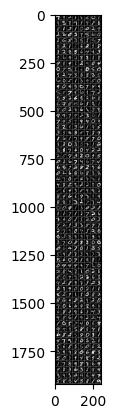

In [ ]:
images, labels = next(iter(dataloader))
img = torchvision.utils.make_grid(images)

img = img.numpy().transpose(1,2,0)
std = [0.5,0.5,0.5]
mean = [0.5,0.5,0.5]
img = img*std+mean
print([labels[i] for i in range(64)])
plt.imshow(img)

In [ ]:
# image

channels = 1
img_size = 28

img_shape = (channels, img_size, img_size)

In [ ]:
latent_dim = 100

class Generator(nn.Module):
  """
  Generator class

  Args:
      latent_dim (int): Dimensionality of the latent space.
      img_shape (tuple): Shape of the generated images (channels, height, width)

  Returns:
      Generates an image from a latent vector sampled from a normal distribution
  """
  def __init__(self):
    super(Generator, self).__init__()

    def block(input_dim, output_dim, normalize=True):
      layers = [nn.Linear(input_dim, output_dim)]
      if normalize:
        layers.append(nn.BatchNorm1d(output_dim, 0.8))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
      return layers

        # generater model consists of blocks
    self.model = nn.Sequential(
        *block(latent_dim, 128, normalize=False),
        *block(128, 256),
        *block(256, 512),
        *block(512, 1024),
        nn.Linear(1024, int(np.prod(img_shape))),
        nn.Tanh()
        )

  def forward(self, z):
    # z : input noise vector
    img = self.model(z)
    img = img.view(img.size(0), *img_shape)
    return img

In [ ]:
# Discriminator

class Discriminator(nn.Module):
  """
  Discriminator class

  Args:
      img_shape (tuple): Shape of the input images (channels, height, width)

  Returns:
      Validity (float): Probability of whether the input image is real or fake.
  """

  def __init__(self):
    super(Discriminator, self).__init__()

    self.model = nn.Sequential(
        nn.Linear(int(np.prod(img_shape)), 512),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Linear(512, 256),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Linear(256, 1),
        nn.Identity(),
        )

    # Return discriminated result of image
  def forward(self, img):
    img_flat = img.view(img.size(0), -1)
    validity = self.model(img_flat)

    return validity

In [ ]:
"""
Hyper parameter

Args:
    generator (Generator): Generator model.
    discriminator (Discriminator): Discriminator model.
    lr (float): Learning rate.
    b1, b2 (float): Beta parameters for Adam optimizer.
"""

# learning rate
lr = 1e-3

# decay of first order momentum of gradient
b1 = 0.5
b2 = 0.999


# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

# Loss function
adversarial_loss = nn.MSELoss()

# Adam Optimizer
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

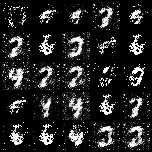

[Epoch 0/500] [D loss: 0.401504] [G loss: 2.319762]
[Epoch 1/500] [D loss: 0.741772] [G loss: 1.096298]
[Epoch 2/500] [D loss: 0.444781] [G loss: 1.967897]
[Epoch 3/500] [D loss: 0.446792] [G loss: 2.248830]
[Epoch 4/500] [D loss: 0.381462] [G loss: 2.025629]
[Epoch 5/500] [D loss: 0.529849] [G loss: 2.015924]
[Epoch 6/500] [D loss: 0.457668] [G loss: 1.796712]
[Epoch 7/500] [D loss: 0.427723] [G loss: 2.181488]
[Epoch 8/500] [D loss: 0.347959] [G loss: 2.468388]
[Epoch 9/500] [D loss: 0.491169] [G loss: 2.103975]
[Epoch 10/500] [D loss: 0.429798] [G loss: 3.403474]
[Epoch 11/500] [D loss: 0.680515] [G loss: 1.046985]
[Epoch 12/500] [D loss: 0.455011] [G loss: 1.975838]
[Epoch 13/500] [D loss: 0.366064] [G loss: 2.424439]
[Epoch 14/500] [D loss: 0.523883] [G loss: 1.612392]
[Epoch 15/500] [D loss: 0.463042] [G loss: 1.957383]


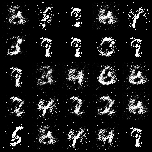

[Epoch 16/500] [D loss: 0.489327] [G loss: 3.428002]
[Epoch 17/500] [D loss: 0.824626] [G loss: 0.801295]
[Epoch 18/500] [D loss: 0.329456] [G loss: 2.732877]
[Epoch 19/500] [D loss: 0.438853] [G loss: 2.416009]
[Epoch 20/500] [D loss: 0.349679] [G loss: 2.481478]
[Epoch 21/500] [D loss: 0.366869] [G loss: 2.025103]
[Epoch 22/500] [D loss: 0.403501] [G loss: 2.868728]
[Epoch 23/500] [D loss: 0.361314] [G loss: 2.722137]
[Epoch 24/500] [D loss: 0.360469] [G loss: 2.425443]
[Epoch 25/500] [D loss: 0.453632] [G loss: 1.838084]
[Epoch 26/500] [D loss: 0.492060] [G loss: 3.292751]
[Epoch 27/500] [D loss: 0.388844] [G loss: 2.276973]
[Epoch 28/500] [D loss: 0.507475] [G loss: 3.743470]
[Epoch 29/500] [D loss: 0.467386] [G loss: 1.925984]
[Epoch 30/500] [D loss: 0.338117] [G loss: 2.381730]
[Epoch 31/500] [D loss: 0.331856] [G loss: 2.590856]
[Epoch 32/500] [D loss: 0.274788] [G loss: 2.768783]


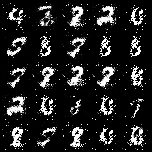

[Epoch 33/500] [D loss: 0.620406] [G loss: 4.401245]
[Epoch 34/500] [D loss: 0.434644] [G loss: 3.304171]
[Epoch 35/500] [D loss: 0.374410] [G loss: 2.072551]
[Epoch 36/500] [D loss: 0.429324] [G loss: 1.664437]
[Epoch 37/500] [D loss: 0.336730] [G loss: 2.419213]
[Epoch 38/500] [D loss: 0.281353] [G loss: 2.802378]
[Epoch 39/500] [D loss: 0.357473] [G loss: 2.895562]
[Epoch 40/500] [D loss: 0.211278] [G loss: 3.047555]
[Epoch 41/500] [D loss: 1.200092] [G loss: 5.990478]
[Epoch 42/500] [D loss: 0.357346] [G loss: 2.708662]
[Epoch 43/500] [D loss: 0.373564] [G loss: 2.417329]
[Epoch 44/500] [D loss: 0.437040] [G loss: 1.995986]
[Epoch 45/500] [D loss: 0.396386] [G loss: 2.367529]
[Epoch 46/500] [D loss: 0.452273] [G loss: 3.511806]
[Epoch 47/500] [D loss: 0.367823] [G loss: 2.077367]
[Epoch 48/500] [D loss: 0.357574] [G loss: 2.806163]
[Epoch 49/500] [D loss: 0.334920] [G loss: 2.343493]


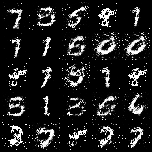

[Epoch 50/500] [D loss: 0.496985] [G loss: 3.320967]
[Epoch 51/500] [D loss: 0.422545] [G loss: 2.504870]
[Epoch 52/500] [D loss: 0.531145] [G loss: 1.458682]
[Epoch 53/500] [D loss: 0.390502] [G loss: 2.279874]
[Epoch 54/500] [D loss: 0.462550] [G loss: 2.019511]
[Epoch 55/500] [D loss: 0.381355] [G loss: 2.460198]
[Epoch 56/500] [D loss: 2.323427] [G loss: 0.255889]
[Epoch 57/500] [D loss: 0.502287] [G loss: 2.328393]
[Epoch 58/500] [D loss: 0.503656] [G loss: 2.188432]
[Epoch 59/500] [D loss: 0.355769] [G loss: 2.797926]
[Epoch 60/500] [D loss: 0.413847] [G loss: 2.340493]
[Epoch 61/500] [D loss: 0.777525] [G loss: 1.184977]
[Epoch 62/500] [D loss: 0.406790] [G loss: 2.934152]
[Epoch 63/500] [D loss: 0.513283] [G loss: 2.409453]
[Epoch 64/500] [D loss: 0.396362] [G loss: 2.748183]
[Epoch 65/500] [D loss: 0.422048] [G loss: 2.161822]
[Epoch 66/500] [D loss: 0.413694] [G loss: 2.363461]


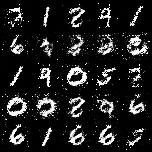

[Epoch 67/500] [D loss: 0.353039] [G loss: 2.403736]
[Epoch 68/500] [D loss: 0.520456] [G loss: 3.680690]
[Epoch 69/500] [D loss: 0.409137] [G loss: 2.570278]
[Epoch 70/500] [D loss: 0.412570] [G loss: 2.472808]
[Epoch 71/500] [D loss: 0.642629] [G loss: 1.334998]
[Epoch 72/500] [D loss: 0.501202] [G loss: 1.759443]
[Epoch 73/500] [D loss: 0.594126] [G loss: 3.856093]
[Epoch 74/500] [D loss: 0.413142] [G loss: 2.397285]
[Epoch 75/500] [D loss: 0.542166] [G loss: 1.699078]
[Epoch 76/500] [D loss: 0.316341] [G loss: 2.699636]
[Epoch 77/500] [D loss: 0.391119] [G loss: 2.366559]
[Epoch 78/500] [D loss: 0.400531] [G loss: 2.172133]
[Epoch 79/500] [D loss: 0.439454] [G loss: 2.085091]
[Epoch 80/500] [D loss: 0.556655] [G loss: 1.450289]
[Epoch 81/500] [D loss: 0.430353] [G loss: 2.590877]
[Epoch 82/500] [D loss: 0.494057] [G loss: 2.190060]
[Epoch 83/500] [D loss: 0.527301] [G loss: 3.832635]


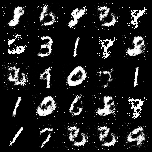

[Epoch 84/500] [D loss: 0.449771] [G loss: 2.431500]
[Epoch 85/500] [D loss: 0.434525] [G loss: 2.427094]
[Epoch 86/500] [D loss: 0.483075] [G loss: 1.984218]
[Epoch 87/500] [D loss: 0.444884] [G loss: 2.512419]
[Epoch 88/500] [D loss: 0.491210] [G loss: 2.640511]
[Epoch 89/500] [D loss: 0.445225] [G loss: 2.264863]
[Epoch 90/500] [D loss: 0.355298] [G loss: 2.415909]
[Epoch 91/500] [D loss: 0.403810] [G loss: 2.650720]
[Epoch 92/500] [D loss: 0.332751] [G loss: 2.625849]
[Epoch 93/500] [D loss: 0.462940] [G loss: 2.701417]
[Epoch 94/500] [D loss: 0.411391] [G loss: 2.443192]
[Epoch 95/500] [D loss: 0.427494] [G loss: 2.019414]
[Epoch 96/500] [D loss: 0.396746] [G loss: 2.169728]
[Epoch 97/500] [D loss: 0.400941] [G loss: 2.132216]
[Epoch 98/500] [D loss: 0.378606] [G loss: 2.286270]
[Epoch 99/500] [D loss: 0.639367] [G loss: 3.409777]
[Epoch 100/500] [D loss: 0.456427] [G loss: 2.841749]


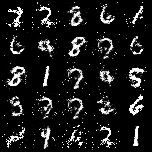

[Epoch 101/500] [D loss: 0.384100] [G loss: 2.712853]
[Epoch 102/500] [D loss: 0.410659] [G loss: 2.183916]
[Epoch 103/500] [D loss: 0.385409] [G loss: 2.569256]
[Epoch 104/500] [D loss: 0.467681] [G loss: 2.481140]
[Epoch 105/500] [D loss: 0.412381] [G loss: 2.923813]
[Epoch 106/500] [D loss: 0.492419] [G loss: 3.570080]
[Epoch 107/500] [D loss: 0.366250] [G loss: 2.096415]
[Epoch 108/500] [D loss: 0.420302] [G loss: 2.627507]
[Epoch 109/500] [D loss: 0.398311] [G loss: 2.507050]
[Epoch 110/500] [D loss: 0.384313] [G loss: 2.599565]
[Epoch 111/500] [D loss: 0.459671] [G loss: 2.709212]
[Epoch 112/500] [D loss: 0.378995] [G loss: 2.456731]
[Epoch 113/500] [D loss: 0.480804] [G loss: 2.668865]
[Epoch 114/500] [D loss: 0.550509] [G loss: 3.277541]
[Epoch 115/500] [D loss: 0.460369] [G loss: 2.823808]
[Epoch 116/500] [D loss: 0.498359] [G loss: 2.947229]
[Epoch 117/500] [D loss: 0.471022] [G loss: 2.377754]


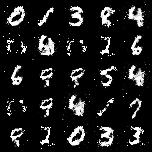

[Epoch 118/500] [D loss: 0.443044] [G loss: 2.378612]
[Epoch 119/500] [D loss: 0.428065] [G loss: 1.943187]
[Epoch 120/500] [D loss: 0.500448] [G loss: 2.850596]
[Epoch 121/500] [D loss: 0.442396] [G loss: 2.514804]
[Epoch 122/500] [D loss: 0.328909] [G loss: 2.612766]
[Epoch 123/500] [D loss: 0.516790] [G loss: 1.641193]
[Epoch 124/500] [D loss: 0.473029] [G loss: 1.954312]
[Epoch 125/500] [D loss: 0.436773] [G loss: 2.394074]
[Epoch 126/500] [D loss: 0.624063] [G loss: 1.369512]
[Epoch 127/500] [D loss: 0.413667] [G loss: 2.346581]
[Epoch 128/500] [D loss: 0.345293] [G loss: 2.966907]
[Epoch 129/500] [D loss: 0.661808] [G loss: 4.199011]
[Epoch 130/500] [D loss: 0.384568] [G loss: 2.047033]
[Epoch 131/500] [D loss: 0.340395] [G loss: 2.446238]
[Epoch 132/500] [D loss: 0.488199] [G loss: 1.987664]
[Epoch 133/500] [D loss: 0.515221] [G loss: 2.409065]
[Epoch 134/500] [D loss: 0.356738] [G loss: 2.808761]


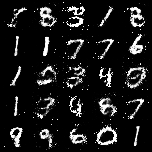

[Epoch 135/500] [D loss: 0.418400] [G loss: 2.257749]
[Epoch 136/500] [D loss: 0.474306] [G loss: 2.046707]
[Epoch 137/500] [D loss: 0.408720] [G loss: 2.617997]
[Epoch 138/500] [D loss: 0.435874] [G loss: 1.898431]
[Epoch 139/500] [D loss: 0.561500] [G loss: 3.039086]
[Epoch 140/500] [D loss: 0.504892] [G loss: 1.873414]
[Epoch 141/500] [D loss: 0.507584] [G loss: 2.566682]
[Epoch 142/500] [D loss: 0.497999] [G loss: 2.298735]
[Epoch 143/500] [D loss: 0.512561] [G loss: 2.967907]
[Epoch 144/500] [D loss: 0.378146] [G loss: 2.761417]
[Epoch 145/500] [D loss: 0.977900] [G loss: 4.839095]
[Epoch 146/500] [D loss: 0.470440] [G loss: 1.946256]
[Epoch 147/500] [D loss: 0.444794] [G loss: 2.309302]
[Epoch 148/500] [D loss: 0.460494] [G loss: 2.241269]
[Epoch 149/500] [D loss: 0.372377] [G loss: 2.142048]
[Epoch 150/500] [D loss: 0.544714] [G loss: 1.795808]
[Epoch 151/500] [D loss: 0.498095] [G loss: 3.175256]


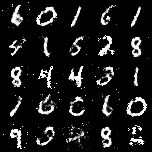

[Epoch 152/500] [D loss: 0.460026] [G loss: 2.551937]
[Epoch 153/500] [D loss: 0.420563] [G loss: 2.458384]
[Epoch 154/500] [D loss: 0.534555] [G loss: 2.463055]
[Epoch 155/500] [D loss: 0.515427] [G loss: 2.599043]
[Epoch 156/500] [D loss: 0.384816] [G loss: 2.385298]
[Epoch 157/500] [D loss: 0.646082] [G loss: 3.174479]
[Epoch 158/500] [D loss: 0.457098] [G loss: 2.193103]
[Epoch 159/500] [D loss: 0.792182] [G loss: 4.720541]
[Epoch 160/500] [D loss: 0.530601] [G loss: 2.733007]
[Epoch 161/500] [D loss: 0.470599] [G loss: 2.729633]
[Epoch 162/500] [D loss: 0.417933] [G loss: 2.590868]
[Epoch 163/500] [D loss: 0.474365] [G loss: 2.350945]
[Epoch 164/500] [D loss: 0.448017] [G loss: 2.340518]
[Epoch 165/500] [D loss: 0.657617] [G loss: 1.584769]
[Epoch 166/500] [D loss: 1.531352] [G loss: 7.238620]
[Epoch 167/500] [D loss: 0.470735] [G loss: 3.010607]
[Epoch 168/500] [D loss: 0.935716] [G loss: 0.897326]


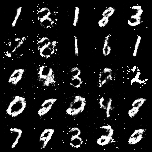

[Epoch 169/500] [D loss: 0.773737] [G loss: 4.553411]
[Epoch 170/500] [D loss: 0.510228] [G loss: 1.956610]
[Epoch 171/500] [D loss: 0.404899] [G loss: 2.188848]
[Epoch 172/500] [D loss: 0.441403] [G loss: 2.410514]
[Epoch 173/500] [D loss: 0.562597] [G loss: 1.594163]
[Epoch 174/500] [D loss: 0.476336] [G loss: 3.465554]
[Epoch 175/500] [D loss: 0.412120] [G loss: 2.324153]
[Epoch 176/500] [D loss: 0.504763] [G loss: 1.946298]
[Epoch 177/500] [D loss: 0.532857] [G loss: 1.498857]
[Epoch 178/500] [D loss: 0.444894] [G loss: 2.281102]
[Epoch 179/500] [D loss: 0.416621] [G loss: 2.612690]
[Epoch 180/500] [D loss: 0.717811] [G loss: 1.172106]
[Epoch 181/500] [D loss: 0.439797] [G loss: 2.411437]
[Epoch 182/500] [D loss: 0.878736] [G loss: 0.943900]
[Epoch 183/500] [D loss: 0.435942] [G loss: 2.182111]
[Epoch 184/500] [D loss: 0.438643] [G loss: 2.403441]
[Epoch 185/500] [D loss: 0.381579] [G loss: 2.643629]


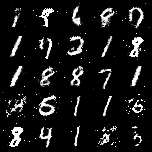

[Epoch 186/500] [D loss: 0.463336] [G loss: 2.252879]
[Epoch 187/500] [D loss: 0.623745] [G loss: 1.674868]
[Epoch 188/500] [D loss: 0.836603] [G loss: 3.422681]
[Epoch 189/500] [D loss: 0.491755] [G loss: 1.775061]
[Epoch 190/500] [D loss: 0.782752] [G loss: 0.915569]
[Epoch 191/500] [D loss: 0.644764] [G loss: 2.363282]
[Epoch 192/500] [D loss: 0.801006] [G loss: 0.885798]
[Epoch 193/500] [D loss: 0.598298] [G loss: 1.407786]
[Epoch 194/500] [D loss: 0.586510] [G loss: 1.517585]
[Epoch 195/500] [D loss: 0.602477] [G loss: 3.147467]
[Epoch 196/500] [D loss: 0.465777] [G loss: 2.001762]
[Epoch 197/500] [D loss: 0.563062] [G loss: 2.055295]
[Epoch 198/500] [D loss: 0.530169] [G loss: 2.277458]
[Epoch 199/500] [D loss: 0.778705] [G loss: 0.817598]
[Epoch 200/500] [D loss: 0.570783] [G loss: 2.431837]
[Epoch 201/500] [D loss: 0.631455] [G loss: 3.103123]
[Epoch 202/500] [D loss: 0.589980] [G loss: 2.967231]


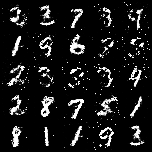

[Epoch 203/500] [D loss: 0.631880] [G loss: 3.441251]
[Epoch 204/500] [D loss: 0.466737] [G loss: 2.748849]
[Epoch 205/500] [D loss: 0.519157] [G loss: 2.020767]
[Epoch 206/500] [D loss: 0.538468] [G loss: 2.179262]
[Epoch 207/500] [D loss: 0.471684] [G loss: 1.865857]
[Epoch 208/500] [D loss: 0.512426] [G loss: 2.857262]
[Epoch 209/500] [D loss: 0.502436] [G loss: 1.917542]
[Epoch 210/500] [D loss: 0.510290] [G loss: 2.653825]
[Epoch 211/500] [D loss: 0.446114] [G loss: 3.111288]
[Epoch 212/500] [D loss: 0.384287] [G loss: 2.554225]
[Epoch 213/500] [D loss: 0.444044] [G loss: 2.081471]
[Epoch 214/500] [D loss: 0.380957] [G loss: 2.254146]
[Epoch 215/500] [D loss: 0.437346] [G loss: 2.345898]
[Epoch 216/500] [D loss: 0.490193] [G loss: 2.600157]
[Epoch 217/500] [D loss: 0.376693] [G loss: 2.739116]
[Epoch 218/500] [D loss: 0.433358] [G loss: 2.466624]
[Epoch 219/500] [D loss: 0.424232] [G loss: 2.521516]


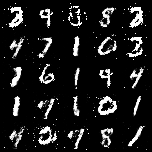

[Epoch 220/500] [D loss: 0.458812] [G loss: 1.634808]
[Epoch 221/500] [D loss: 0.605545] [G loss: 2.324433]
[Epoch 222/500] [D loss: 0.454265] [G loss: 2.517145]
[Epoch 223/500] [D loss: 0.456418] [G loss: 3.123192]
[Epoch 224/500] [D loss: 0.450812] [G loss: 1.900776]
[Epoch 225/500] [D loss: 0.502939] [G loss: 1.891287]
[Epoch 226/500] [D loss: 0.488039] [G loss: 2.853532]
[Epoch 227/500] [D loss: 0.432610] [G loss: 2.677017]
[Epoch 228/500] [D loss: 0.411445] [G loss: 3.138716]
[Epoch 229/500] [D loss: 0.464054] [G loss: 3.018292]
[Epoch 230/500] [D loss: 0.514074] [G loss: 1.881671]
[Epoch 231/500] [D loss: 0.509996] [G loss: 2.565035]
[Epoch 232/500] [D loss: 0.607698] [G loss: 3.663915]
[Epoch 233/500] [D loss: 0.478029] [G loss: 2.656062]
[Epoch 234/500] [D loss: 0.423047] [G loss: 2.213618]
[Epoch 235/500] [D loss: 0.426564] [G loss: 2.147093]
[Epoch 236/500] [D loss: 0.622949] [G loss: 1.414254]


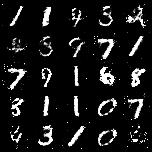

[Epoch 237/500] [D loss: 0.385417] [G loss: 2.515041]
[Epoch 238/500] [D loss: 0.570318] [G loss: 2.687777]
[Epoch 239/500] [D loss: 1.282282] [G loss: 6.323720]
[Epoch 240/500] [D loss: 0.447200] [G loss: 2.219873]
[Epoch 241/500] [D loss: 0.503863] [G loss: 1.654077]
[Epoch 242/500] [D loss: 0.475608] [G loss: 1.923389]
[Epoch 243/500] [D loss: 0.446945] [G loss: 2.121542]
[Epoch 244/500] [D loss: 0.371943] [G loss: 2.320724]
[Epoch 245/500] [D loss: 0.556061] [G loss: 3.760153]
[Epoch 246/500] [D loss: 0.408189] [G loss: 2.789146]
[Epoch 247/500] [D loss: 0.423315] [G loss: 2.367490]
[Epoch 248/500] [D loss: 0.385609] [G loss: 2.515168]
[Epoch 249/500] [D loss: 0.391438] [G loss: 2.269549]
[Epoch 250/500] [D loss: 0.538146] [G loss: 2.643328]
[Epoch 251/500] [D loss: 0.491484] [G loss: 2.905402]
[Epoch 252/500] [D loss: 0.404148] [G loss: 2.845446]
[Epoch 253/500] [D loss: 0.525990] [G loss: 3.476152]


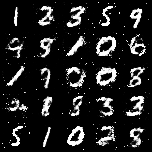

[Epoch 254/500] [D loss: 0.469767] [G loss: 2.520639]
[Epoch 255/500] [D loss: 0.690506] [G loss: 3.924241]
[Epoch 256/500] [D loss: 0.534570] [G loss: 1.556445]
[Epoch 257/500] [D loss: 0.453164] [G loss: 2.674147]
[Epoch 258/500] [D loss: 0.408901] [G loss: 2.377906]
[Epoch 259/500] [D loss: 0.381605] [G loss: 2.378917]
[Epoch 260/500] [D loss: 0.514628] [G loss: 1.945079]
[Epoch 261/500] [D loss: 0.425571] [G loss: 2.674811]
[Epoch 262/500] [D loss: 0.475172] [G loss: 2.591635]
[Epoch 263/500] [D loss: 0.528203] [G loss: 2.000807]
[Epoch 264/500] [D loss: 0.450239] [G loss: 2.655552]
[Epoch 265/500] [D loss: 0.430494] [G loss: 2.416549]
[Epoch 266/500] [D loss: 0.508402] [G loss: 3.549644]
[Epoch 267/500] [D loss: 0.517852] [G loss: 1.722512]
[Epoch 268/500] [D loss: 0.413898] [G loss: 3.413090]
[Epoch 269/500] [D loss: 0.405995] [G loss: 2.970343]
[Epoch 270/500] [D loss: 0.374351] [G loss: 2.826180]


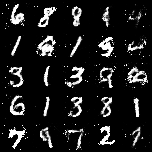

[Epoch 271/500] [D loss: 0.503218] [G loss: 2.749996]
[Epoch 272/500] [D loss: 0.392668] [G loss: 2.929920]
[Epoch 273/500] [D loss: 0.432370] [G loss: 2.312479]
[Epoch 274/500] [D loss: 0.585490] [G loss: 3.304575]
[Epoch 275/500] [D loss: 0.453465] [G loss: 2.605203]
[Epoch 276/500] [D loss: 0.470109] [G loss: 1.937228]
[Epoch 277/500] [D loss: 0.575488] [G loss: 1.481789]
[Epoch 278/500] [D loss: 0.561864] [G loss: 2.222050]
[Epoch 279/500] [D loss: 0.508704] [G loss: 1.741024]
[Epoch 280/500] [D loss: 0.555464] [G loss: 1.617613]
[Epoch 281/500] [D loss: 0.486796] [G loss: 1.812387]
[Epoch 282/500] [D loss: 0.490586] [G loss: 3.475204]
[Epoch 283/500] [D loss: 0.413059] [G loss: 2.270622]
[Epoch 284/500] [D loss: 0.555776] [G loss: 1.737369]
[Epoch 285/500] [D loss: 0.513990] [G loss: 1.951720]
[Epoch 286/500] [D loss: 0.522328] [G loss: 2.395030]
[Epoch 287/500] [D loss: 0.442555] [G loss: 2.778627]


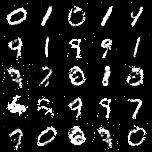

[Epoch 288/500] [D loss: 0.399860] [G loss: 2.333735]
[Epoch 289/500] [D loss: 0.449560] [G loss: 2.794378]
[Epoch 290/500] [D loss: 0.621315] [G loss: 4.067365]
[Epoch 291/500] [D loss: 0.436987] [G loss: 2.060555]
[Epoch 292/500] [D loss: 0.502651] [G loss: 3.080708]
[Epoch 293/500] [D loss: 0.464730] [G loss: 2.413056]
[Epoch 294/500] [D loss: 0.464905] [G loss: 3.381095]
[Epoch 295/500] [D loss: 0.521911] [G loss: 2.551184]
[Epoch 296/500] [D loss: 0.504835] [G loss: 3.245655]
[Epoch 297/500] [D loss: 0.429531] [G loss: 2.414396]
[Epoch 298/500] [D loss: 0.419284] [G loss: 2.704794]
[Epoch 299/500] [D loss: 0.471448] [G loss: 2.066641]
[Epoch 300/500] [D loss: 0.462691] [G loss: 2.459839]
[Epoch 301/500] [D loss: 0.427656] [G loss: 2.253343]
[Epoch 302/500] [D loss: 0.405582] [G loss: 2.275699]
[Epoch 303/500] [D loss: 0.430268] [G loss: 2.260123]
[Epoch 304/500] [D loss: 0.408498] [G loss: 2.501556]


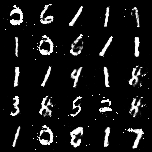

[Epoch 305/500] [D loss: 0.411775] [G loss: 2.325646]
[Epoch 306/500] [D loss: 0.493729] [G loss: 3.204777]
[Epoch 307/500] [D loss: 0.516936] [G loss: 1.828424]
[Epoch 308/500] [D loss: 0.445995] [G loss: 3.391390]
[Epoch 309/500] [D loss: 0.379170] [G loss: 2.597406]
[Epoch 310/500] [D loss: 0.362024] [G loss: 2.509537]
[Epoch 311/500] [D loss: 0.470597] [G loss: 2.608542]
[Epoch 312/500] [D loss: 0.459878] [G loss: 2.363085]
[Epoch 313/500] [D loss: 0.476590] [G loss: 2.288290]
[Epoch 314/500] [D loss: 0.437298] [G loss: 2.247068]
[Epoch 315/500] [D loss: 0.367506] [G loss: 2.609375]
[Epoch 316/500] [D loss: 0.405509] [G loss: 2.459368]
[Epoch 317/500] [D loss: 0.449514] [G loss: 2.210817]
[Epoch 318/500] [D loss: 0.485600] [G loss: 1.700117]
[Epoch 319/500] [D loss: 0.424516] [G loss: 2.330669]
[Epoch 320/500] [D loss: 0.390352] [G loss: 2.320733]
[Epoch 321/500] [D loss: 0.360154] [G loss: 2.446297]


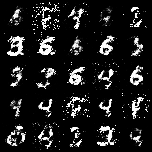

[Epoch 322/500] [D loss: 0.507215] [G loss: 1.560661]
[Epoch 323/500] [D loss: 0.471560] [G loss: 2.156722]
[Epoch 324/500] [D loss: 0.436585] [G loss: 2.042651]
[Epoch 325/500] [D loss: 0.711360] [G loss: 0.927347]
[Epoch 326/500] [D loss: 0.471759] [G loss: 1.953960]
[Epoch 327/500] [D loss: 0.540540] [G loss: 2.784787]
[Epoch 328/500] [D loss: 0.530706] [G loss: 2.131421]
[Epoch 329/500] [D loss: 0.724532] [G loss: 1.810523]
[Epoch 330/500] [D loss: 0.950536] [G loss: 0.587136]
[Epoch 331/500] [D loss: 0.542720] [G loss: 1.870107]
[Epoch 332/500] [D loss: 0.535102] [G loss: 1.561798]
[Epoch 333/500] [D loss: 0.478858] [G loss: 1.983804]
[Epoch 334/500] [D loss: 0.702939] [G loss: 1.007843]
[Epoch 335/500] [D loss: 0.536294] [G loss: 1.830239]
[Epoch 336/500] [D loss: 0.543629] [G loss: 1.683715]
[Epoch 337/500] [D loss: 0.611014] [G loss: 1.661463]


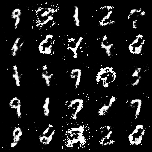

[Epoch 338/500] [D loss: 0.667870] [G loss: 2.174967]
[Epoch 339/500] [D loss: 0.591664] [G loss: 1.601604]
[Epoch 340/500] [D loss: 0.715816] [G loss: 1.409827]
[Epoch 341/500] [D loss: 0.571559] [G loss: 2.024207]
[Epoch 342/500] [D loss: 0.552108] [G loss: 1.630239]
[Epoch 343/500] [D loss: 0.582333] [G loss: 2.185682]
[Epoch 344/500] [D loss: 0.522253] [G loss: 1.573125]
[Epoch 345/500] [D loss: 0.546631] [G loss: 2.065949]
[Epoch 346/500] [D loss: 0.523279] [G loss: 2.015008]
[Epoch 347/500] [D loss: 0.534588] [G loss: 1.715576]
[Epoch 348/500] [D loss: 0.661624] [G loss: 2.762191]
[Epoch 349/500] [D loss: 0.585146] [G loss: 2.556415]
[Epoch 350/500] [D loss: 0.474388] [G loss: 1.955610]
[Epoch 351/500] [D loss: 0.640597] [G loss: 1.636481]
[Epoch 352/500] [D loss: 0.644045] [G loss: 1.883574]
[Epoch 353/500] [D loss: 0.532459] [G loss: 1.869612]
[Epoch 354/500] [D loss: 0.545607] [G loss: 1.990139]


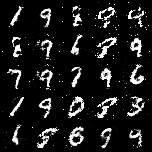

[Epoch 355/500] [D loss: 0.556531] [G loss: 2.837682]
[Epoch 356/500] [D loss: 0.535849] [G loss: 1.736405]
[Epoch 357/500] [D loss: 0.501160] [G loss: 3.139879]
[Epoch 358/500] [D loss: 0.517208] [G loss: 1.831483]
[Epoch 359/500] [D loss: 0.629027] [G loss: 1.387824]
[Epoch 360/500] [D loss: 0.529399] [G loss: 2.175770]
[Epoch 361/500] [D loss: 0.510591] [G loss: 2.668298]
[Epoch 362/500] [D loss: 0.573765] [G loss: 3.276805]
[Epoch 363/500] [D loss: 0.473538] [G loss: 2.739413]
[Epoch 364/500] [D loss: 0.354816] [G loss: 2.354822]
[Epoch 365/500] [D loss: 0.406314] [G loss: 2.422072]
[Epoch 366/500] [D loss: 0.551827] [G loss: 1.765856]
[Epoch 367/500] [D loss: 0.611877] [G loss: 1.374196]
[Epoch 368/500] [D loss: 0.508442] [G loss: 1.649820]
[Epoch 369/500] [D loss: 0.451529] [G loss: 1.982964]
[Epoch 370/500] [D loss: 0.415649] [G loss: 2.367270]
[Epoch 371/500] [D loss: 0.536805] [G loss: 1.608116]


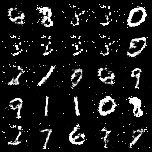

[Epoch 372/500] [D loss: 0.395548] [G loss: 2.550201]
[Epoch 373/500] [D loss: 0.532998] [G loss: 1.655241]
[Epoch 374/500] [D loss: 0.411795] [G loss: 2.500411]
[Epoch 375/500] [D loss: 0.490831] [G loss: 2.527583]
[Epoch 376/500] [D loss: 0.366886] [G loss: 2.609903]
[Epoch 377/500] [D loss: 0.509255] [G loss: 2.497182]
[Epoch 378/500] [D loss: 0.453096] [G loss: 2.519952]
[Epoch 379/500] [D loss: 0.495751] [G loss: 3.268152]
[Epoch 380/500] [D loss: 0.466542] [G loss: 2.271495]
[Epoch 381/500] [D loss: 0.407235] [G loss: 2.121840]
[Epoch 382/500] [D loss: 0.539396] [G loss: 2.886040]
[Epoch 383/500] [D loss: 0.377289] [G loss: 2.427369]
[Epoch 384/500] [D loss: 0.357125] [G loss: 2.530112]
[Epoch 385/500] [D loss: 0.381705] [G loss: 2.715430]
[Epoch 386/500] [D loss: 0.416565] [G loss: 2.309201]
[Epoch 387/500] [D loss: 0.481739] [G loss: 1.915872]
[Epoch 388/500] [D loss: 0.447822] [G loss: 3.480202]


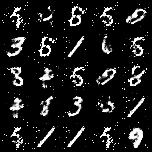

[Epoch 389/500] [D loss: 0.432619] [G loss: 3.198917]
[Epoch 390/500] [D loss: 0.407377] [G loss: 2.975458]
[Epoch 391/500] [D loss: 0.450350] [G loss: 2.251504]
[Epoch 392/500] [D loss: 0.373650] [G loss: 2.646170]
[Epoch 393/500] [D loss: 0.482583] [G loss: 2.956872]
[Epoch 394/500] [D loss: 0.488014] [G loss: 1.965758]
[Epoch 395/500] [D loss: 0.366080] [G loss: 2.568841]
[Epoch 396/500] [D loss: 0.432579] [G loss: 2.484205]
[Epoch 397/500] [D loss: 0.729319] [G loss: 1.899400]
[Epoch 398/500] [D loss: 0.636465] [G loss: 1.832056]
[Epoch 399/500] [D loss: 1.395930] [G loss: 4.987511]
[Epoch 400/500] [D loss: 0.726062] [G loss: 2.920702]
[Epoch 401/500] [D loss: 0.577443] [G loss: 2.008199]
[Epoch 402/500] [D loss: 0.564094] [G loss: 2.745089]
[Epoch 403/500] [D loss: 0.561314] [G loss: 1.754066]
[Epoch 404/500] [D loss: 0.575465] [G loss: 2.066679]
[Epoch 405/500] [D loss: 0.495038] [G loss: 2.009308]


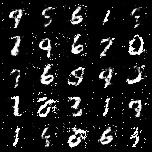

[Epoch 406/500] [D loss: 0.741185] [G loss: 0.991201]
[Epoch 407/500] [D loss: 0.563297] [G loss: 1.739366]
[Epoch 408/500] [D loss: 0.319137] [G loss: 2.860492]
[Epoch 409/500] [D loss: 0.517971] [G loss: 2.017734]
[Epoch 410/500] [D loss: 0.690719] [G loss: 3.215799]
[Epoch 411/500] [D loss: 0.543323] [G loss: 2.141127]
[Epoch 412/500] [D loss: 0.560146] [G loss: 1.571041]
[Epoch 413/500] [D loss: 0.575116] [G loss: 2.182130]
[Epoch 414/500] [D loss: 0.513758] [G loss: 1.947628]
[Epoch 415/500] [D loss: 0.556895] [G loss: 2.371632]
[Epoch 416/500] [D loss: 0.542852] [G loss: 2.116812]
[Epoch 417/500] [D loss: 0.535805] [G loss: 2.098824]
[Epoch 418/500] [D loss: 0.573847] [G loss: 2.132897]
[Epoch 419/500] [D loss: 0.498755] [G loss: 2.070266]
[Epoch 420/500] [D loss: 0.615866] [G loss: 1.555881]
[Epoch 421/500] [D loss: 0.548318] [G loss: 2.349343]
[Epoch 422/500] [D loss: 0.731121] [G loss: 3.842382]


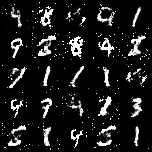

[Epoch 423/500] [D loss: 0.514634] [G loss: 1.938358]
[Epoch 424/500] [D loss: 0.523434] [G loss: 1.856375]
[Epoch 425/500] [D loss: 0.592168] [G loss: 2.384449]
[Epoch 426/500] [D loss: 0.383773] [G loss: 2.793459]
[Epoch 427/500] [D loss: 0.411345] [G loss: 2.230003]
[Epoch 428/500] [D loss: 0.444109] [G loss: 2.170752]
[Epoch 429/500] [D loss: 0.504567] [G loss: 2.369253]
[Epoch 430/500] [D loss: 0.443666] [G loss: 1.928922]
[Epoch 431/500] [D loss: 0.459388] [G loss: 2.186230]
[Epoch 432/500] [D loss: 0.455260] [G loss: 2.304514]
[Epoch 433/500] [D loss: 0.747212] [G loss: 1.093485]
[Epoch 434/500] [D loss: 0.395703] [G loss: 2.716205]
[Epoch 435/500] [D loss: 0.568769] [G loss: 1.768676]
[Epoch 436/500] [D loss: 0.366568] [G loss: 2.720455]
[Epoch 437/500] [D loss: 0.500798] [G loss: 1.577612]
[Epoch 438/500] [D loss: 0.532522] [G loss: 1.877834]
[Epoch 439/500] [D loss: 0.438095] [G loss: 2.149479]


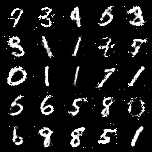

[Epoch 440/500] [D loss: 0.541407] [G loss: 3.181339]
[Epoch 441/500] [D loss: 0.569500] [G loss: 2.376690]
[Epoch 442/500] [D loss: 0.435670] [G loss: 2.650253]
[Epoch 443/500] [D loss: 0.469202] [G loss: 2.175853]
[Epoch 444/500] [D loss: 0.397746] [G loss: 2.880517]
[Epoch 445/500] [D loss: 0.500189] [G loss: 2.271551]
[Epoch 446/500] [D loss: 0.408093] [G loss: 2.338783]
[Epoch 447/500] [D loss: 0.414646] [G loss: 2.649089]
[Epoch 448/500] [D loss: 0.521819] [G loss: 2.269109]
[Epoch 449/500] [D loss: 0.552008] [G loss: 1.572790]
[Epoch 450/500] [D loss: 0.730714] [G loss: 4.279709]
[Epoch 451/500] [D loss: 0.423018] [G loss: 2.166934]
[Epoch 452/500] [D loss: 0.439449] [G loss: 2.708473]
[Epoch 453/500] [D loss: 0.366472] [G loss: 2.713444]
[Epoch 454/500] [D loss: 0.448419] [G loss: 1.888103]
[Epoch 455/500] [D loss: 0.453616] [G loss: 3.384333]
[Epoch 456/500] [D loss: 0.434700] [G loss: 2.718700]


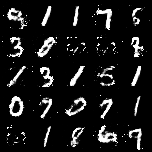

[Epoch 457/500] [D loss: 0.404976] [G loss: 2.330010]
[Epoch 458/500] [D loss: 0.661877] [G loss: 4.035353]
[Epoch 459/500] [D loss: 0.413538] [G loss: 2.487174]
[Epoch 460/500] [D loss: 0.730445] [G loss: 1.198113]
[Epoch 461/500] [D loss: 0.448863] [G loss: 2.987906]
[Epoch 462/500] [D loss: 0.417090] [G loss: 2.515366]
[Epoch 463/500] [D loss: 0.408422] [G loss: 2.633829]
[Epoch 464/500] [D loss: 0.356553] [G loss: 2.630450]
[Epoch 465/500] [D loss: 0.550672] [G loss: 2.673009]
[Epoch 466/500] [D loss: 0.472806] [G loss: 2.118479]
[Epoch 467/500] [D loss: 0.407726] [G loss: 2.959940]
[Epoch 468/500] [D loss: 0.701656] [G loss: 4.149799]
[Epoch 469/500] [D loss: 0.418249] [G loss: 2.342272]
[Epoch 470/500] [D loss: 0.540834] [G loss: 1.636208]
[Epoch 471/500] [D loss: 0.406720] [G loss: 2.345813]
[Epoch 472/500] [D loss: 0.309292] [G loss: 2.741354]
[Epoch 473/500] [D loss: 0.631050] [G loss: 2.507912]


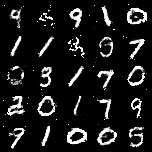

[Epoch 474/500] [D loss: 0.438918] [G loss: 2.592874]
[Epoch 475/500] [D loss: 0.395582] [G loss: 2.423383]
[Epoch 476/500] [D loss: 0.420851] [G loss: 2.545544]
[Epoch 477/500] [D loss: 0.453136] [G loss: 2.770463]
[Epoch 478/500] [D loss: 0.438625] [G loss: 2.926216]
[Epoch 479/500] [D loss: 0.455703] [G loss: 2.707507]
[Epoch 480/500] [D loss: 0.469318] [G loss: 2.600612]
[Epoch 481/500] [D loss: 0.528275] [G loss: 3.032987]
[Epoch 482/500] [D loss: 0.419778] [G loss: 2.629443]
[Epoch 483/500] [D loss: 0.324648] [G loss: 2.595132]
[Epoch 484/500] [D loss: 0.454046] [G loss: 2.632869]
[Epoch 485/500] [D loss: 0.390392] [G loss: 2.374831]
[Epoch 486/500] [D loss: 0.465029] [G loss: 2.145462]
[Epoch 487/500] [D loss: 0.582913] [G loss: 1.537938]
[Epoch 488/500] [D loss: 0.464215] [G loss: 2.636970]
[Epoch 489/500] [D loss: 0.812319] [G loss: 1.030808]
[Epoch 490/500] [D loss: 0.428942] [G loss: 2.498820]


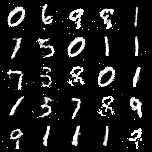

[Epoch 491/500] [D loss: 0.494047] [G loss: 4.063758]
[Epoch 492/500] [D loss: 0.437448] [G loss: 2.258446]
[Epoch 493/500] [D loss: 0.448695] [G loss: 2.091022]
[Epoch 494/500] [D loss: 0.431580] [G loss: 2.156850]
[Epoch 495/500] [D loss: 0.606466] [G loss: 2.121524]
[Epoch 496/500] [D loss: 0.421967] [G loss: 2.203564]
[Epoch 497/500] [D loss: 0.618502] [G loss: 1.788455]
[Epoch 498/500] [D loss: 0.626043] [G loss: 1.795724]
[Epoch 499/500] [D loss: 0.685700] [G loss: 1.183290]


In [ ]:
import time
from IPython.display import Image, display

# number of epochs of training
n_epochs = 500

# interval between image samples
sample_interval = 2000

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

"""
Training loop

Args:
    dataloader (troch.utils.data.DataLoader): Provides training images.
    n_epochs (int): Number of epochs for training.
    sample_interval (int): Interval to save and display generated images.

Returns:
    Logs generator and discriminator losses. Saves generated image samples.
"""

generator.to(device)
discriminator.to(device)
adversarial_loss.to(device)

for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(dataloader):

        # Adversarial ground truths
        # real image = 1, fake image = 0
        real = torch.ones((imgs.size(0), 1), device=device)
        fake = -torch.ones((imgs.size(0), 1), device=device)
        #real = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
        #fake = Variable(Tensor(imgs.size(0), 1).fill_(-1.0), requires_grad=False)

        # Configure input
        #real_imgs = Variable(imgs.type(Tensor))
        real_imgs = imgs.to(device)

        # Train Generator
        optimizer_G.zero_grad()

        # Sample noise as generator input
        # z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))
        z = torch.randn((imgs.shape[0], latent_dim), device=device)
        # Generate a batch of images
        # random sampling value z to Generator
        generated_imgs = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(generated_imgs), real)

        # Update Generator
        g_loss.backward()
        optimizer_G.step()

        #  Train Discriminator
        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), real)
        fake_loss = adversarial_loss(discriminator(generated_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        # Update Discriminator
        d_loss.backward()
        optimizer_D.step()

        done = epoch * len(dataloader) + i
        if done % sample_interval == 0:
            img_path = f"data{epoch}.png"
            save_image(generated_imgs.data[:25], img_path, nrow=5, normalize=True)
            display(Image(filename=img_path))

    print(f"[Epoch {epoch}/{n_epochs}] [D loss: {d_loss.item():.6f}] [G loss: {g_loss.item():.6f}]")